# Business Understanding
## Problem Statement
The Tunisian Company of Electricity and Gas (STEG) is a public and a non-administrative company, it is responsible for delivering electricity and gas across Tunisia. The company suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers.

## Objective
Using the client’s billing history, the aim of the challenge is to detect and recognize clients involved in fraudulent activities.

## Data Understanding

In [1]:
!pip install lightgbm

     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.8 kB 2.7 MB/s eta 0:00:01
     ---------------------------------------- 60.8/60.8 kB 3.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 3.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ----------- ---------------------------- 0.4/1.4 MB 12.6 MB/s eta 0:00:01
   ------------------------- -------------- 0.9/1.4 MB 11.6 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 11.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   --- ------------------------------------ 1.0/12.6 MB 20.7 MB/s eta 0:00:01
   ------ --------------------------------- 2.2/12.6 MB 23.0 MB/s eta 0:00:01
   ---------- ----------------------------- 3.4/12.6 MB 24.3 MB/s eta 0:00:01
   ---------


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from lightgbm import LGBMClassifier as lgb
# importing package to load data
import pandas as pd
# function for loading data
def load_data(path):
    return pd.read_csv(path,low_memory = False)
# loading client train dataset
client_train = load_data('data/client_train.csv')
# Previewing client train
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [2]:
# loading invoice train dataset
invoice_train = load_data('data/invoice_train.csv')
# Previewing invoice train
invoice_train.head(5)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [3]:
# loading client test dataset
client_test = load_data('data/client_test.csv')
# Previewing client test
client_test.head()

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [4]:
# loading invoice test dataset
invoice_test = load_data('data/invoice_test.csv')
# Previewing invoice test
invoice_test.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,test_Client_0,2018-03-16,11,651208,0,203,8,1,755,0,0,0,19145,19900,8,ELEC
1,test_Client_0,2014-03-21,11,651208,0,203,8,1,1067,0,0,0,13725,14792,8,ELEC
2,test_Client_0,2014-07-17,11,651208,0,203,8,1,0,0,0,0,14792,14792,4,ELEC
3,test_Client_0,2015-07-13,11,651208,0,203,9,1,410,0,0,0,16122,16532,4,ELEC
4,test_Client_0,2016-07-19,11,651208,0,203,9,1,412,0,0,0,17471,17883,4,ELEC


In [5]:
# checking the shape of the datasets
print(client_train.shape,invoice_train.shape,client_test.shape,invoice_test.shape)

(135493, 6) (4476749, 16) (58069, 5) (1939730, 16)


In [6]:
# Getting information about client train
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [7]:
# Summary statistics of client train
client_train.describe().T

,count,mean,std,min,25%,50%,75%,max
disrict,135493.0,63.511222,3.354400,60.0,62.0,62.0,69.0,69.0
client_catg,135493.0,11.512506,4.423761,11.0,11.0,11.0,11.0,51.0
region,135493.0,206.159809,104.207044,101.0,103.0,107.0,307.0,399.0
target,135493.0,0.055841,0.229614,0.0,0.0,0.0,0.0,1.0


In [8]:
# Getting information about invoice train
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [9]:
# Summary statistics of invoice train
invoice_train.describe().T

,count,mean,std,min,25%,50%,75%,max
tarif_type,4476749.0,2.012804e+01,1.347256e+01,8.0,11.0,11.0,40.0,4.500000e+01
counter_number,4476749.0,1.230587e+11,1.657267e+12,0.0,121108.0,494561.0,1115161.0,2.798115e+13
counter_code,4476749.0,1.724884e+02,1.338871e+02,0.0,5.0,203.0,207.0,6.000000e+02
reading_remarque,4476749.0,7.321702e+00,1.571654e+00,5.0,6.0,8.0,9.0,4.130000e+02
counter_coefficient,4476749.0,1.003040e+00,3.083466e-01,0.0,1.0,1.0,1.0,5.000000e+01
consommation_level_1,4476749.0,4.109795e+02,7.573080e+02,0.0,79.0,274.0,600.0,9.999100e+05
consommation_level_2,4476749.0,1.093225e+02,1.220123e+03,0.0,0.0,0.0,0.0,9.990730e+05
consommation_level_3,4476749.0,2.030620e+01,1.574239e+02,0.0,0.0,0.0,0.0,6.449200e+04
consommation_level_4,4476749.0,5.292588e+01,8.754725e+02,0.0,0.0,0.0,0.0,5.479460e+05
old_index,4476749.0,1.776700e+04,4.036693e+04,0.0,1791.0,7690.0,21660.0,2.800280e+06


## Data Preparation


In [10]:
# Function to clean client information dataset
def client_cleaning(df):
    # Renaming district column
    df.rename(columns = {'disrict':'district'},inplace =True)
    # Converting region column to the category
    df['region'] = df['region'].astype('object')
    # Converting district column to the category
    df['district'] = df['district'].astype('object')
    # Converting client_catg column to the category
    df['client_catg'] = df['client_catg'].astype('object')
    # Converting creation_date column to date time
    df['creation_date'] = pd.to_datetime(df['creation_date'],
                                               errors='coerce',
                                               infer_datetime_format=True).dt.date
    # Getting unique values on the client train data
    for col in df.columns:
        print(f"Number of unique values in {col} - {df[col].nunique()}")
    return df

### Cleaning `client train` dataset

In [11]:
# cleaned client train dataset
client_cleaning(client_train)

C:\Users\Siddhant Panda\AppData\Local\Temp\ipykernel_15120\504259225.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['creation_date'] = pd.to_datetime(df['creation_date'],
C:\Users\Siddhant Panda\AppData\Local\Temp\ipykernel_15120\504259225.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['creation_date'] = pd.to_datetime(df['creation_date'],


Number of unique values in district - 4
Number of unique values in client_id - 135493
Number of unique values in client_catg - 3
Number of unique values in region - 25
Number of unique values in creation_date - 8088
Number of unique values in target - 2


,district,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,1994-12-31,0.0
1,69,train_Client_1,11,107,2002-05-29,0.0
2,62,train_Client_10,11,301,1986-03-13,0.0
3,69,train_Client_100,11,105,1996-07-11,0.0
4,62,train_Client_1000,11,303,2014-10-14,0.0
...,...,...,...,...,...,...
135488,62,train_Client_99995,11,304,2004-07-26,0.0
135489,63,train_Client_99996,11,311,2012-10-25,0.0
135490,63,train_Client_99997,11,311,2011-11-22,0.0
135491,60,train_Client_99998,11,101,1993-12-22,0.0


In [12]:
import datetime as dt
today_date = dt.date.today()
# Checking if there is any date greater than today in client train
client_train[client_train['creation_date'] > dt.date.today()]

,district,client_id,client_catg,region,creation_date,target


In [13]:
# Checking if there are null values
client_train.isna().sum()

district         0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

In [14]:
# Checking for duplicates
client_train.duplicated().sum()

np.int64(0)

In [15]:
# Checking duplicates on client id
train_duplicates = client_train.duplicated(subset = 'client_id', keep = False)
# Checking the duplicates
client_train[train_duplicates]

,district,client_id,client_catg,region,creation_date,target


### Cleaning `client test` dataset

In [16]:
# cleaned client test dataset
client_cleaning(client_test)

Number of unique values in district - 4
Number of unique values in client_id - 58069
Number of unique values in client_catg - 3
Number of unique values in region - 24
Number of unique values in creation_date - 7388


C:\Users\Siddhant Panda\AppData\Local\Temp\ipykernel_15120\504259225.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['creation_date'] = pd.to_datetime(df['creation_date'],
C:\Users\Siddhant Panda\AppData\Local\Temp\ipykernel_15120\504259225.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['creation_date'] = pd.to_datetime(df['creation_date'],


,district,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,2002-05-28
1,69,test_Client_1,11,103,2009-08-06
2,62,test_Client_10,11,310,2004-04-07
3,60,test_Client_100,11,101,1992-10-08
4,62,test_Client_1000,11,301,1977-07-21
...,...,...,...,...,...
58064,63,test_Client_9995,11,399,2010-03-17
58065,63,test_Client_9996,11,311,2011-05-28
58066,60,test_Client_9997,11,101,1978-03-04
58067,60,test_Client_9998,11,101,2018-02-23


In [17]:
# Checking if there is any date greater than today in client test
client_test[client_test['creation_date'] > dt.date.today()]

,district,client_id,client_catg,region,creation_date


In [18]:
# Checking if there are null values
client_test.isna().sum()

district         0
client_id        0
client_catg      0
region           0
creation_date    0
dtype: int64

In [19]:
# Checking for duplicates
client_test.duplicated().sum()

np.int64(0)

In [20]:
# Checking duplicates on client id
test_duplicates = client_train.duplicated(subset = 'client_id', keep = False)
# Checking the duplicates
client_train[test_duplicates]

,district,client_id,client_catg,region,creation_date,target


## Cleaning `invoice train` dataset

In [21]:
def invoice_cleaning(df):
    # Converting invoice date to datetime
    df['invoice_date'] = pd.to_datetime(df['invoice_date'],errors ='coerce').dt.date
    # Getting unique values on the client train data
    for col in df.columns:
        print(f"Number of unique values in {col} - {df[col].nunique()}")
    
    return df

### Cleaning iinvoice train

In [22]:
# Using function to clean invoice train dataset
invoice_cleaning(invoice_train)

Number of unique values in client_id - 135493
Number of unique values in invoice_date - 8275
Number of unique values in tarif_type - 17
Number of unique values in counter_number - 201893
Number of unique values in counter_statue - 12
Number of unique values in counter_code - 42
Number of unique values in reading_remarque - 8
Number of unique values in counter_coefficient - 16
Number of unique values in consommation_level_1 - 8295
Number of unique values in consommation_level_2 - 12576
Number of unique values in consommation_level_3 - 2253
Number of unique values in consommation_level_4 - 12075
Number of unique values in old_index - 155648
Number of unique values in new_index - 157980
Number of unique values in months_number - 1370
Number of unique values in counter_type - 2


,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,train_Client_99998,2005-08-19,10,1253571,0,202,9,1,400,135,0,0,3197,3732,8,ELEC
4476745,train_Client_99998,2005-12-19,10,1253571,0,202,6,1,200,6,0,0,3732,3938,4,ELEC
4476746,train_Client_99999,1996-09-25,11,560948,0,203,6,1,259,0,0,0,13884,14143,4,ELEC
4476747,train_Client_99999,1996-05-28,11,560948,0,203,6,1,603,0,0,0,13281,13884,4,ELEC


In [23]:
# Checking the columns that are duplicated
invoice_train_duplicates =invoice_train.duplicated()
invoice_train[invoice_train_duplicates]

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
951893,train_Client_125864,2011-12-12,11,101545,5,413,6,1,0,0,0,0,13680,13680,2,ELEC
1755798,train_Client_25894,2010-07-13,40,6986740,5,5,6,1,0,0,0,0,0,0,2,GAZ
2137999,train_Client_3636,2012-01-18,40,312650,5,5,6,1,0,0,0,0,623,623,2,GAZ
2163374,train_Client_37069,2010-10-11,11,5284,5,413,6,1,0,0,0,0,99429,99429,2,ELEC
2433919,train_Client_44407,2008-02-28,11,66921,5,203,6,1,0,0,0,0,0,0,2,ELEC
2805729,train_Client_54609,2010-04-06,11,200912,5,207,6,1,0,0,0,0,0,0,2,ELEC
3260191,train_Client_66981,2006-07-17,11,132701,5,420,6,1,0,0,0,0,5946,5946,2,ELEC
3260198,train_Client_66981,2006-07-17,11,132701,5,420,6,1,0,0,0,0,5946,5946,2,ELEC
3394719,train_Client_7066,2014-10-28,40,4463323,5,5,6,1,0,0,0,0,80,80,2,GAZ
3462929,train_Client_72519,2013-01-21,11,246464,5,203,6,1,0,0,0,0,2954,2954,2,ELEC


In [24]:
# Dropping the duplicated values
invoice_train.drop_duplicates(inplace=True)

In [25]:
# Confirming if the duplicate values have been dropped
invoice_train.duplicated().sum()

np.int64(0)

In [26]:
# Converting counter_type column into binary
values = {'ELEC':0,'GAZ':1}
invoice_train['counter_type'] =invoice_train['counter_type'].map(values)
invoice_train['counter_type'].value_counts()

counter_type
0    3079398
1    1397340
Name: count, dtype: int64

In [27]:
# grouping the invoice_data by the client_id column
## INVOICE TRAIN
aggs = {}
aggs['consommation_level_1'] = ['mean']
aggs['consommation_level_2'] = ['mean']
aggs['consommation_level_3'] = ['mean']
aggs['consommation_level_4'] = ['mean']
agg_trans = invoice_train.groupby(['client_id']).agg(aggs)
agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
agg_trans.reset_index(inplace=True)
df = (invoice_train.groupby('client_id')
      .size()
      .reset_index(name='transactions_count'))
agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')

In [28]:
# Previewing aggregated dataframe
agg_trans.head()

,client_id,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_0,35,352.400000,10.571429,0.000000,0.000000
1,train_Client_1,37,557.540541,0.000000,0.000000,0.000000
2,train_Client_10,18,798.611111,37.888889,0.000000,0.000000
3,train_Client_100,20,1.200000,0.000000,0.000000,0.000000
4,train_Client_1000,14,663.714286,104.857143,117.357143,36.714286


In [29]:
# Merging client train with agg tras
train = pd.merge(client_train,agg_trans, on='client_id', how='left')

In [30]:
# Previwing the merged dataset
train.head()

,district,client_id,client_catg,region,creation_date,target,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,60,train_Client_0,11,101,1994-12-31,0.0,35,352.400000,10.571429,0.000000,0.000000
1,69,train_Client_1,11,107,2002-05-29,0.0,37,557.540541,0.000000,0.000000,0.000000
2,62,train_Client_10,11,301,1986-03-13,0.0,18,798.611111,37.888889,0.000000,0.000000
3,69,train_Client_100,11,105,1996-07-11,0.0,20,1.200000,0.000000,0.000000,0.000000
4,62,train_Client_1000,11,303,2014-10-14,0.0,14,663.714286,104.857143,117.357143,36.714286


### Cleaning `INVOICE TEST`

In [31]:
# Using function to clean invoice test dataset
invoice_cleaning(invoice_test)

Number of unique values in client_id - 58069
Number of unique values in invoice_date - 6934
Number of unique values in tarif_type - 16
Number of unique values in counter_number - 91966
Number of unique values in counter_statue - 6
Number of unique values in counter_code - 39
Number of unique values in reading_remarque - 4
Number of unique values in counter_coefficient - 7
Number of unique values in consommation_level_1 - 6546
Number of unique values in consommation_level_2 - 9700
Number of unique values in consommation_level_3 - 1862
Number of unique values in consommation_level_4 - 8838
Number of unique values in old_index - 116512
Number of unique values in new_index - 118365
Number of unique values in months_number - 914
Number of unique values in counter_type - 2


,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,test_Client_0,2018-03-16,11,651208,0,203,8,1,755,0,0,0,19145,19900,8,ELEC
1,test_Client_0,2014-03-21,11,651208,0,203,8,1,1067,0,0,0,13725,14792,8,ELEC
2,test_Client_0,2014-07-17,11,651208,0,203,8,1,0,0,0,0,14792,14792,4,ELEC
3,test_Client_0,2015-07-13,11,651208,0,203,9,1,410,0,0,0,16122,16532,4,ELEC
4,test_Client_0,2016-07-19,11,651208,0,203,9,1,412,0,0,0,17471,17883,4,ELEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939725,test_Client_9999,2010-03-11,11,869269,0,203,6,1,248,0,0,0,21114,21362,4,ELEC
1939726,test_Client_9999,2011-03-15,11,869269,0,203,6,1,260,0,0,0,21362,21622,4,ELEC
1939727,test_Client_9999,2012-12-03,11,869269,0,203,6,1,312,0,0,0,22272,22584,4,ELEC
1939728,test_Client_9999,2009-07-01,11,869269,0,203,6,1,236,0,0,0,19909,20145,4,ELEC


In [32]:
# Checking the columns that are duplicated
invoice_test_duplicates =invoice_test.duplicated(keep =False)
invoice_test[invoice_test_duplicates]

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
310557,test_Client_18456,2013-11-22,40,0,5,5,6,1,0,0,0,0,0,0,2,GAZ
310558,test_Client_18456,2013-11-22,40,0,5,5,6,1,0,0,0,0,0,0,2,GAZ
1226239,test_Client_43096,2017-07-06,11,9894,0,413,8,1,15,0,0,0,104,119,8,ELEC
1226241,test_Client_43096,2016-10-13,11,9894,0,413,8,1,2,0,0,0,102,104,4,ELEC
1226243,test_Client_43096,2016-07-06,11,9894,0,413,8,1,22,0,0,0,80,102,4,ELEC
1226244,test_Client_43096,2017-07-06,11,9894,0,413,8,1,15,0,0,0,104,119,8,ELEC
1226246,test_Client_43096,2016-07-06,11,9894,0,413,8,1,22,0,0,0,80,102,4,ELEC
1226253,test_Client_43096,2017-12-10,11,9894,0,413,8,1,69,0,0,0,119,188,4,ELEC
1226256,test_Client_43096,2017-12-10,11,9894,0,413,8,1,69,0,0,0,119,188,4,ELEC
1226257,test_Client_43096,2016-02-15,11,9894,0,413,6,1,80,0,0,0,0,80,2,ELEC


In [33]:
# Dropping the duplicated values
invoice_test.drop_duplicates(inplace=True)

In [34]:
# Confirming if the duplicate values have been dropped
invoice_test.duplicated().sum()

np.int64(0)

In [35]:
# Converting counter_type column into binary
invoice_test['counter_type'] =invoice_test['counter_type'].map(values)
invoice_test['counter_type'].value_counts()

counter_type
0    1335788
1     603934
Name: count, dtype: int64

In [36]:
# grouping the invoice_data by the client_id column
## INVOICE TEST
agg = {}
agg['consommation_level_1'] = ['mean']
agg['consommation_level_2'] = ['mean']
agg['consommation_level_3'] = ['mean']
agg['consommation_level_4'] = ['mean']
agg_test = invoice_test.groupby(['client_id']).agg(agg)
agg_test.columns = ['_'.join(col).strip() for col in agg_test.columns.values]
agg_test.reset_index(inplace=True)
df_test = (invoice_test.groupby('client_id')
      .size()
      .reset_index(name='{}transactions_count'.format('1')))
agg_test = pd.merge(df_test, agg_test, on='client_id', how='left')

In [37]:
# Previewing aggregated dataframe
agg_test.head()

,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,test_Client_0,37,488.135135,3.243243,0.000000,0.000000
1,test_Client_1,22,1091.409091,843.136364,182.318182,586.318182
2,test_Client_10,74,554.040541,37.364865,15.743243,0.162162
3,test_Client_100,40,244.350000,0.000000,0.000000,0.000000
4,test_Client_1000,53,568.188679,145.056604,33.679245,0.000000


In [38]:
# Merging client train with agg tras
test = pd.merge(client_test,agg_test, on='client_id', how='left')

In [39]:
# Previwing the merged dataset
test.head()

,district,client_id,client_catg,region,creation_date,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,62,test_Client_0,11,307,2002-05-28,37,488.135135,3.243243,0.000000,0.000000
1,69,test_Client_1,11,103,2009-08-06,22,1091.409091,843.136364,182.318182,586.318182
2,62,test_Client_10,11,310,2004-04-07,74,554.040541,37.364865,15.743243,0.162162
3,60,test_Client_100,11,101,1992-10-08,40,244.350000,0.000000,0.000000,0.000000
4,62,test_Client_1000,11,301,1977-07-21,53,568.188679,145.056604,33.679245,0.000000


In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58069 entries, 0 to 58068
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   district                   58069 non-null  object 
 1   client_id                  58069 non-null  object 
 2   client_catg                58069 non-null  object 
 3   region                     58069 non-null  object 
 4   creation_date              58069 non-null  object 
 5   1transactions_count        58069 non-null  int64  
 6   consommation_level_1_mean  58069 non-null  float64
 7   consommation_level_2_mean  58069 non-null  float64
 8   consommation_level_3_mean  58069 non-null  float64
 9   consommation_level_4_mean  58069 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 4.4+ MB


In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   district                   135493 non-null  object 
 1   client_id                  135493 non-null  object 
 2   client_catg                135493 non-null  object 
 3   region                     135493 non-null  object 
 4   creation_date              135493 non-null  object 
 5   target                     135493 non-null  float64
 6   transactions_count         135493 non-null  int64  
 7   consommation_level_1_mean  135493 non-null  float64
 8   consommation_level_2_mean  135493 non-null  float64
 9   consommation_level_3_mean  135493 non-null  float64
 10  consommation_level_4_mean  135493 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 11.4+ MB


## EXPLOLATORY DATA ANALYSIS

In [42]:
# Importing libraries necessary for visualizing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

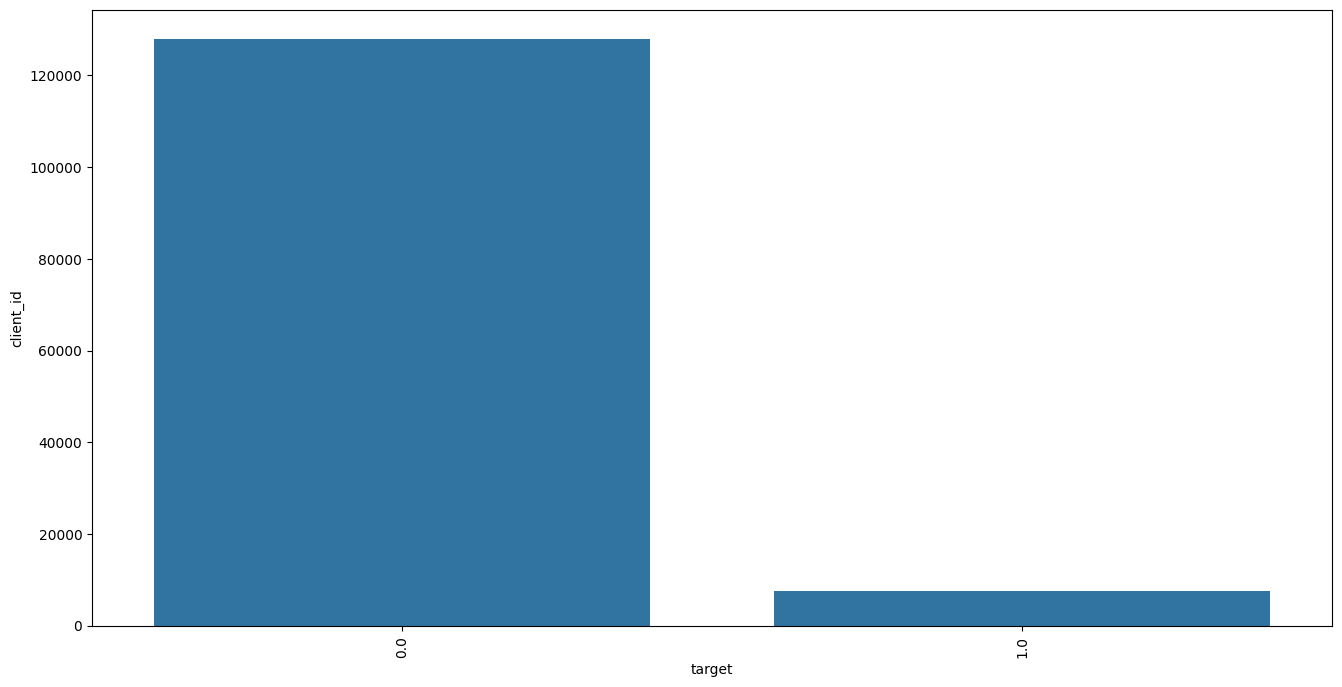

In [43]:
# Checking how many people are involved in fraudulent activities
client_target = train.groupby("target").client_id.count().reset_index()
plt.figure(figsize=(16,8))
sns.barplot(data = client_target,x = 'target', y = 'client_id')
plt.xticks(rotation=90);

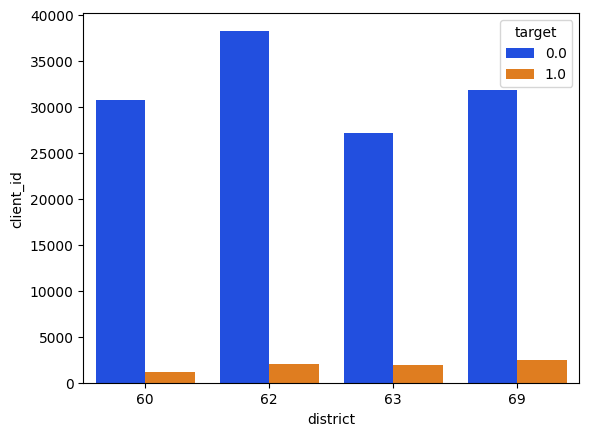

In [44]:
# Checking which district has many fraduent activities
district_clients = train.groupby(["target","district"]).client_id.count().reset_index()
sns.barplot(
    x='district', 
    y='client_id', 
    data=district_clients, 
    palette='bright',hue='target');

In [45]:
train['target'].value_counts()

target
0.0    127927
1.0      7566
Name: count, dtype: int64

## Feature Engineering

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [47]:
# Dropping useless columns
train.drop(['creation_date','client_id'],axis=1,inplace=True)
test.drop(['creation_date','client_id'],axis=1,inplace=True)

In [48]:
# Determining the predictor variables
X = train.drop(["target"],axis = 1)

# Determining the target variables

y = train.target

# Splitting the data to training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2,random_state =42)

In [49]:
# Select the categorical columns
categorical_cols = ['district', 'client_catg', 'region']

# Perform one-hot encoding on the categorical columns
x_train_cat = pd.get_dummies(X_train, columns=categorical_cols)
x_test_cat = pd.get_dummies(X_test, columns=categorical_cols)

Scaling data using StandardScaler

In [50]:
# Instantiating standard scaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_cat)
x_test_scaled = scaler.transform(x_test_cat)

SMOTE

In [51]:
!pip install imblearn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
from imblearn.over_sampling import SMOTE
# Instantiating smote
smote = SMOTE()
# Fitting smote
X_train_resampled, y_train_resampled = smote.fit_resample(x_train_scaled, y_train)

## Modeling
Models to be used:
* Logistic regression
* Decision tree classifier
* random forest classifier
* gradient boosting classifier
* K nearest neighbour
* SGDClassifier
* LGBMClassifier
* AdaBoostRegressor
* CatBoostClassifier



### Logistic regression

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

In [54]:
# Instantiating logistic regression
lr = LogisticRegression(random_state = 42,
                            multi_class ="ovr")

# Fitting the model to unbalanced classes data
lr.fit(X_train_resampled, y_train_resampled)

LogisticRegression(multi_class='ovr', random_state=42)

In [55]:
# Predicting on training and test sets
lr_train_pred = lr.predict(X_train_resampled)
lr_test_pred = lr.predict(x_test_scaled)
# Evaluating the model on the training set
lr_train_auc = roc_auc_score(y_train_resampled,lr_train_pred)

# Evaluating the model on the testing set
lr_test_auc = roc_auc_score(y_test,lr_test_pred)

# Evaluating the balanced classes data
print(f'baseline logreg Train AUC - {lr_train_auc} \nbaseline logreg Test AUC - {lr_test_auc}')

baseline logreg Train AUC - 0.6460221501679818 
baseline logreg Test AUC - 0.6420293569279816


In [56]:
# from sklearn.model_selection import GridSearchCV
# import numpy as np
# # Creating a parameter grid for logistiv regression
# param_grid = {'penalty': ['l1', 'l2','none'],
#               'C': [0.1, 1, 10],
#               'solver': ['newton-cg', 'lbfgs', 'sag'],'tol': [1e-3, 1e-4,1e-5]}
# # Create a GridSearchCv
# lr_clf = GridSearchCV(estimator = lr,scoring='roc_auc',
#                           param_grid = param_grid,
#                           cv = 3, verbose=True, n_jobs=-1)
# # Fitting using grid search
# best_lr = lr_clf.fit(X_train_resampled,y_train_resampled)

In [57]:
# # Getting the best hyperparameters for logistic regression 
# best_lr.best_params_

In [58]:
# Instantiating logistic regression model using the best parameters from the grid search
best_logreg =LogisticRegression(random_state = 42,multi_class ="ovr",tol =  0.0001,
                                 C = 1,solver = "newton-cg",penalty='l2')
# Fitting the model
best_logreg.fit(X_train_resampled,y_train_resampled)


LogisticRegression(C=1, multi_class='ovr', random_state=42, solver='newton-cg')

In [59]:
# Predicting the values of y from the model on the training set
best_logreg_train_pred = best_logreg.predict(X_train_resampled)
# Predicting the values of y from the model on the testing
best_logreg_test_pred = best_logreg.predict(x_test_scaled)
# Evaluating the model on the training set
best_logreg_train_auc = roc_auc_score(y_train_resampled,best_logreg_train_pred)
# Evaluating the model on the testing set
best_logreg_test_auc = roc_auc_score(y_test,best_logreg_test_pred)
print(f'Best logreg Train AUC - {best_logreg_train_auc} \nBest logreg Test AUC - {best_logreg_test_auc}')


Best logreg Train AUC - 0.6460563325259786 
Best logreg Test AUC - 0.6420489378952814


### Decision tree classifier

In [60]:
# Importing decision tree classifier
from sklearn.tree import DecisionTreeClassifier
# Instantiate decision tree classifier
dt=DecisionTreeClassifier()
# Fitting the model
dt.fit(X_train_resampled,y_train_resampled)
# Evaluating the model 
dt_train_pred = dt.predict(X_train_resampled)
dt_test_pred = dt.predict(x_test_scaled)
dt_train_auc = roc_auc_score(y_train_resampled,dt_train_pred)
dt_test_auc = roc_auc_score(y_test,dt_test_pred)
print(f'Train AUC - {dt_train_auc} \nTest AUC - {dt_test_auc}')

Train AUC - 0.9997607234940229 
Test AUC - 0.5713690827042969


In [61]:
# # compute ccp_alpha values
# path = dt.cost_complexity_pruning_path(X_train_resampled, y_train_resampled)
# ccp_alphas, impurities = path.ccp_alphas, path.impurities

# # train DT classifier for each ccp_alpha value
# clfs = []
# for ccp_alpha in ccp_alphas:
#     clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
#     clf.fit(X_train, y_train)
#     clfs.append(clf)

# # Plot train and test score for each of the above trained model    
# clfs = clfs[:-1]
# ccp_alphas = ccp_alphas[:-1]

# train_scores = [roc_auc_score(y_train_resampled, clf.predict(X_train_resampled)) for clf in clfs]
# test_scores = [roc_auc_score(y_test, clf.predict(x_test_scaled)) for clf in clfs]

# fig, ax = plt.subplots()
# ax.set_xlabel("alpha")
# ax.set_ylabel("accuracy")
# ax.set_title("AUC-ROC score vs alpha")
# ax.plot(ccp_alphas, train_scores, marker='o', label="train")
# ax.plot(ccp_alphas, test_scores, marker='o', label="test")
# ax.legend()
# plt.show()

In [62]:
# dt_param_grid = {
#     'max_depth': [3, 5, 7, None],
#     'min_samples_leaf': [5, 10, 15, 20],
#     'max_features': ['auto', 'sqrt', 'log2', None],
#     'min_samples_split': [10,20,30,40]}
# # Instantiating GridSearchCV
# dt_clf = GridSearchCV(estimator = dt,scoring='roc_auc',
#                           param_grid = dt_param_grid)
# # Fitting using grid search
# best_dt = dt_clf.fit(X_train_resampled,y_train_resampled)

In [63]:
# # Getting the best hyperparameters for decision tree classifier
# best_dt.best_params_

In [64]:
# Instantiating decision tree classifier with the best estimated hyperparameters
best_dt = DecisionTreeClassifier(max_depth=350,max_features=4,
                                 min_samples_leaf=500,min_samples_split=4,criterion='entropy')
# Fitting the model
best_dt.fit(X_train_resampled,y_train_resampled)

DecisionTreeClassifier(criterion='entropy', max_depth=350, max_features=4,
                       min_samples_leaf=500, min_samples_split=4)

In [65]:
# Evaluating the model 
best_dt_train_pred = best_dt.predict(X_train_resampled)
best_dt_test_pred = best_dt.predict(x_test_scaled)
best_dt_train_auc = roc_auc_score(y_train_resampled,best_dt_train_pred)
best_dt_test_auc = roc_auc_score(y_test,best_dt_test_pred)
print(f'best dt train AUC - {best_dt_train_auc} \nTest AUC - {best_dt_test_auc}')

best dt train AUC - 0.712834010469568 
Test AUC - 0.657569471118574


### Random forest classifier

In [66]:
from sklearn.ensemble import RandomForestClassifier
# Instantiating random forest classifier
rf = RandomForestClassifier(random_state=42)
# Fitting the model to the training data+
rf.fit(X_train_resampled, y_train_resampled)
# Evaluating random forest baseline model
rf_train_pred = rf.predict(X_train_resampled)
rf_test_pred = rf.predict(x_test_scaled)
rf_train_auc = roc_auc_score(y_train_resampled,rf_train_pred)
rf_test_auc = roc_auc_score(y_test,rf_test_pred)
print(f'Train AUC - {rf_train_auc} \nTest AUC - {rf_test_auc}')

Train AUC - 0.9997460739120245 
Test AUC - 0.5930118607577884


In [67]:
# # Parameter grid 
# rf_param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 5],
#     'max_features': ['auto', 'sqrt']
# }

# # Instantiating GridSearchCV
# rf_clf = GridSearchCV(estimator = rf,scoring='roc_auc',
#                           param_grid = rf_param_grid)
# # Fitting using grid search
# rf_clf.fit(X_train_resampled,y_train_resampled)

In [68]:
# Getting the best hyperparameters for decision tree classifier
# rf_clf.best_params_

In [70]:
# Instantiating decision tree classifier with the best estimated hyperparameters
best_rf = RandomForestClassifier(random_state = 42,max_depth=None,
                                 max_features= 2,n_estimators=200)
# Fitting the model
best_rf.fit(X_train_resampled,y_train_resampled)

RandomForestClassifier(max_features=2, n_estimators=200, random_state=42)

In [71]:
# Evaluating the model 
best_rf_train_pred = best_rf.predict(X_train_resampled)
best_rf_test_pred = best_rf.predict(x_test_scaled)
best_rf_train_auc = roc_auc_score(y_train_resampled,best_rf_train_pred)
best_rf_test_auc = roc_auc_score(y_test,best_rf_test_pred)
print(f'Train AUC - {best_rf_train_auc} \nTest AUC - {best_rf_test_auc}')

Train AUC - 0.9997558403000233 
Test AUC - 0.5918893480038682


### Gradient Boosting Classifier

In [72]:
from sklearn.ensemble import GradientBoostingClassifier
# Instantiating GradientBoostingClassifier baseline model and fitting the model to the set
gb = GradientBoostingClassifier(random_state=42).fit(X_train_resampled,y_train_resampled)

# Predicting the value of y using the model for both training and testing set
gb_train_pred = gb.predict(X_train_resampled)
gb_test_pred = gb.predict(x_test_scaled)

# Evaluating the model using area under the curve
gb_train_auc = roc_auc_score(y_train_resampled,gb_train_pred)
gb_test_auc = roc_auc_score(y_test,gb_test_pred)
print(f'Train AUC - {gb_train_auc} \nTest AUC - {gb_test_auc}')

Train AUC - 0.7498095554340184 
Test AUC - 0.6661971157385405


In [73]:
# gb_param_grid = {
#     'learning_rate': [0.1, 0.5],
#     'max_depth': [3, 5],
#     'max_features': [None, 'sqrt']}
# # Instantiating GridSearchCV
# gb_clf = GridSearchCV(estimator = gb,scoring='roc_auc',
#                           param_grid = gb_param_grid)
# # Fitting using grid search
# gb_clf.fit(X_train_resampled,y_train_resampled)

In [74]:
# gb_clf.best_params_

In [75]:
best_gb_clf = GradientBoostingClassifier(random_state=42,n_estimators = 800,
                                         learning_rate=0.007,
                                         max_depth=1,
                                         max_features=4).fit(X_train_resampled,
                                                                  y_train_resampled)
# Predicting the value of y using the model for both training and testing set
best_gb_train_pred = best_gb_clf.predict(X_train_resampled)
best_gb_test_pred = best_gb_clf.predict(x_test_scaled)

# Evaluating the model using area under the curve
best_gb_train_auc = roc_auc_score(y_train_resampled,best_gb_train_pred)
best_gb_test_auc = roc_auc_score(y_test,best_gb_test_pred)
print(f'Train AUC - {best_gb_train_auc} \nTest AUC - {best_gb_test_auc}')

Train AUC - 0.7026476677865459 
Test AUC - 0.65471742310464


### LGBMClassifier

In [76]:
# from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier 

lgb = LGBMClassifier(random_state=42).fit(X_train_resampled,y_train_resampled)

# Predicting the value of y using the model for both training and testing set
lgb_train_pred = lgb.predict(X_train_resampled)
lgb_test_pred = lgb.predict(x_test_scaled)

# Evaluating the model using area under the curve
lgb_train_auc = roc_auc_score(y_train_resampled,lgb_train_pred)
lgb_test_auc = roc_auc_score(y_test,lgb_test_pred)

print(f'Train AUC - {lgb_train_auc} \nTest AUC - {lgb_test_auc}')

[LightGBM] [Info] Number of positive: 102392, number of negative: 102392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 204784, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Train AUC - 0.8526203219001485 
Test AUC - 0.6402475264631015


In [77]:
# lgb_param_grid = {
#     'n_estimators': [800, 830, 860, 900],
#     'num_leaves': [400, 450, 500, 550, 600],
#     'max_depth': [50, 55, 60, 65, 70],
#     'learning_rate': [0.005, 0.006, 0.007, 0.008, 0.01],
#     'min_split_gain': [0.004, 0.005, 0.006, 0.007, 0.008],
#     'bagging_freq': [5, 7, 8, 9, 10]
# }
# # Instantiating GridSearchCV
# lgb_clf = GridSearchCV(estimator = lgb,scoring='roc_auc',
#                           param_grid = lgb_param_grid)
# # Fitting using grid search
# lgb_clf.fit(X_train_resampled,y_train_resampled)

In [78]:
# lgb_clf.best_params_

In [79]:
best_lgb = LGBMClassifier(random_state=42,n_estimators=830,
                     num_leaves=454, max_depth=61,
                     learning_rate=0.006,
                     min_split_gain=0.006,
                     bagging_freq=8).fit(X_train_resampled,y_train_resampled)

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Number of positive: 102392, number of negative: 102392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 204784, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [80]:
# Predicting the value of y using the model for both training and testing set
best_lgb_train_pred = best_lgb.predict(X_train_resampled)
best_lgb_test_pred = best_lgb.predict(x_test_scaled)

# Evaluating the model using area under the curve
best_lgb_train_auc = roc_auc_score(y_train_resampled,best_lgb_train_pred)
best_lgb_test_auc = roc_auc_score(y_test,best_lgb_test_pred)

print(f'Train AUC - {best_lgb_train_auc} \nTest AUC - {best_lgb_test_auc}')

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
Train AUC - 0.9182943979998437 
Test AUC - 0.6015435411102659


In [81]:
# Create a dictionary to store the AUC scores
models = {'Model': ['Baseline Logistic Regression', 'Tuned Logistic Regression', 
                    'Decision Tree', 'Tuned Decision Tree', 'Random Forest',
                    'Tuned Random Forest','Gradient Boosting Classifier',
                    'Tuned Gradient Boosting Classifier','LGBMClassifier',
                    'Tuned LGBMClassifier'],
          'Train AUC': [lr_train_auc, best_logreg_train_auc, dt_train_auc, 
                        best_dt_train_auc, rf_train_auc,best_rf_train_auc,
                        gb_train_auc,best_gb_train_auc,lgb_train_auc,best_lgb_train_auc],
          'Test AUC': [lr_test_auc, best_logreg_test_auc, dt_test_auc, 
                       best_dt_test_auc, rf_test_auc,best_rf_test_auc,
                       gb_test_auc,best_gb_test_auc,lgb_test_auc,best_lgb_test_auc]}

# Convert the dictionary to a Pandas DataFrame
auc_df = pd.DataFrame(models)

# Set the 'Model' column as the index of the DataFrame
auc_df = auc_df.set_index('Model')

# Compute the difference between train and test AUC scores
auc_df['AUC Difference'] = auc_df['Train AUC'] - auc_df['Test AUC']

# Sort the values by AUC Difference in descending order
auc_df = auc_df.sort_values('AUC Difference', ascending=True)

# Print the DataFrame
auc_df


,Train AUC,Test AUC,AUC Difference
Model,,,
Baseline Logistic Regression,0.646022,0.642029,0.003993
Tuned Logistic Regression,0.646056,0.642049,0.004007
Tuned Gradient Boosting Classifier,0.702648,0.654717,0.047930
Tuned Decision Tree,0.712834,0.657569,0.055265
Gradient Boosting Classifier,0.749810,0.666197,0.083612
LGBMClassifier,0.852620,0.640248,0.212373
Tuned LGBMClassifier,0.918294,0.601544,0.316751
Random Forest,0.999746,0.593012,0.406734
Tuned Random Forest,0.999756,0.591889,0.407866


In [82]:
import pickle

# Open a file to write the model to
with open('model.pkl', 'wb') as f:
    # Use the `pickle` module to serialize the model and write it to the file
    pickle.dump(best_logreg, f)

In [3]:
!jupyter nbconvert --to script  Frauddetection.ipynb

[NbConvertApp] Converting notebook Frauddetection.ipynb to script
[NbConvertApp] Writing 22304 bytes to Frauddetection.py
